In [1]:
%matplotlib inline

# Transfer Learning
In this assignment, we will use the weights of a network pre-trained in a particular problem as starting point to train our CNN to a different problem. As training a network from scratch is time-consuming and demands a lot of data, this is a frequent strategy, specially if both datasets (the one used for pre-training and the target) shares similar structures/elements/concepts. 

This is specially true when working with images. Most filters learned in initial convolutional layers will detect low-level elements, such as borders, corners and color blobs, which are common to most problems in the image domain. 

In this notebook, we will load the SqueezeNet architecture trained in the ImageNet dataset and fine-tune it to CIFAR-10.

## Imports

In [12]:
import os
import numpy as np
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, Flatten, Dense
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from sklearn.cross_validation import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

#Utility to plot
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

## SqueezeNet definition
These methods define our architecture and load the weights obtained using ImageNet data.

In [3]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The class are **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**.

In [28]:
#Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()
print("Train/Val data. X: ", trainVal_data.shape, ", Y: ", trainVal_data.shape)
print("Test data. X: ", X_test.shape, ", Y: ", y_test.shape)

# Prepare the data
# ...

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(trainVal_data)

Train/Val data. X:  (50000, 32, 32, 3) , Y:  (50000, 32, 32, 3)
Test data. X:  (10000, 32, 32, 3) , Y:  (10000, 1)


[59 62 63]


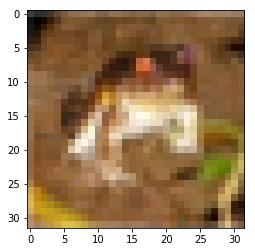

In [29]:
print(trainVal_data[0][0][0])
plt.imshow(trainVal_data[0])
plt.show()

-----------------
-----------------

# Training last 2 Fire Modules + classification layers
As we could see, the frozen network performed very poorly. By freezing most layers, we do not allow SqueezeNet to adapt its weights to features present in CIFAR-10.

Let's try to unfreeze the last two fire modules and train once more. The architecture will be:
<img src="partFrozenSqueezeNet.png" width=70% height=70%>

In [5]:
squeezeNetModel = SqueezeNet((32,32,3))

#freeze the mentioned layers
# ...
for layer in squeezeNetModel.layers[:-19]:
    layer.trainable = False

for layer in squeezeNetModel.layers:
    print(layer.name, layer.trainable)

#Add new classification layers
# ...
x = squeezeNetModel.layers[-5].output
x = Convolution2D(1000, (1, 1), padding='valid', name='new_conv10')(x)
x = Activation('relu', name='new_relu_conv10')(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax', name='new_loss')(x)

#new Model
model = Model(squeezeNetModel.inputs, x, name='squeezenet_new')

input_1 False
conv1 False
relu_conv1 False
pool1 False
fire2/squeeze1x1 False
fire2/relu_squeeze1x1 False
fire2/expand1x1 False
fire2/expand3x3 False
fire2/relu_expand1x1 False
fire2/relu_expand3x3 False
fire2/concat False
fire3/squeeze1x1 False
fire3/relu_squeeze1x1 False
fire3/expand1x1 False
fire3/expand3x3 False
fire3/relu_expand1x1 False
fire3/relu_expand3x3 False
fire3/concat False
pool3 False
fire4/squeeze1x1 False
fire4/relu_squeeze1x1 False
fire4/expand1x1 False
fire4/expand3x3 False
fire4/relu_expand1x1 False
fire4/relu_expand3x3 False
fire4/concat False
fire5/squeeze1x1 False
fire5/relu_squeeze1x1 False
fire5/expand1x1 False
fire5/expand3x3 False
fire5/relu_expand1x1 False
fire5/relu_expand3x3 False
fire5/concat False
pool5 False
fire6/squeeze1x1 False
fire6/relu_squeeze1x1 False
fire6/expand1x1 False
fire6/expand3x3 False
fire6/relu_expand1x1 False
fire6/relu_expand3x3 False
fire6/concat False
fire7/squeeze1x1 False
fire7/relu_squeeze1x1 False
fire7/expand1x1 False
fire7/ex

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

In [7]:
model.layers[-20].trainable

False

Now, we compile our model and train it:

In [ ]:
#Compile model and train it
# ...
from keras import optimizers

model.fit_generator(datagen.flow(trainVal_data, trainVal_label, batch_size=20),
                    steps_per_epoch=len(trainVal_data) / 20, epochs=10)

model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizers.Adam(), metrics=["accuracy"])

history = model.fit(trainVal_data, trainVal_label, batch_size=20, epochs=100, validation_split=0.2)

Epoch 1/10
2500/2500 [==============================] - 65s 26ms/step - loss: 1.6373 - acc: 0.4283
Epoch 2/10
1418/2500 [================>.............] - ETA: 29s - loss: 1.4778 - acc: 0.4861

Finally, let's evaluate on our test set:

In [9]:
# Evaluate on validation.

score = history.history['val_loss'][-1], history.history['val_acc'][-1]
print('Validation loss:', score[0])
print('Validation accuracy (NORMALIZED):', score[1])

Validation loss: 1.6139479713439941
Validation accuracy (NORMALIZED): 0.4880000024139881


-----------
-----------
-----------
# Tensorboard

Tensorboard is a visualization tool for Tensorflow. Among other things, it allows us to monitor the progress of our training, plot metrics per epochs, visualize the architecture's schematics. 

Just like for Early Stopping, we will use the [Tensorboard callback](https://keras.io/callbacks/#tensorboard) to log the information about our training. An example of usage, would be:

As your training progresses, Keras will log the metrics (e.g., loss, accuracy) to `<<LOG_DIR>>` (**make sure `<<LOG_DIR>>` is a valid directory)**. On your terminal, you will need to run Tensorboard, assign a port and access it via browser (just like jupyter).

#### ----> MAKE SURE YOU USE A DIFFERENT PORT FOR JUPYTER AND TENSORBOARD <----

### Docker
For those using docker, open a new terminal and create a new container (using the same image) running Tensorboard:

For example:

After starting Tensorboard, access it via browser on `http://localhost:<<port_container>>`.

### Anaconda
$ tensorboard --logdir=<<LOG_DIR>> --port=<<port>>

After starting Tensorboard, access it via browser on `http://localhost:<<port>>`.

-----------
-----------
-----------

# Fine-tuning all layers

What if we fine-tune all layers of SqueezeNet?
<img src="unfrozenSqueezeNet.png" width=70% height=70%>

In [10]:
squeezeNetModel = SqueezeNet((32,32,3))

for layer in squeezeNetModel.layers:
    layer.trainable = True       #by default they are all trainable, but just for clarification

#Add new classification layers
# ...

#new Model
model = Model(squeezeNetModel.inputs, x, name='squeezenet_new')

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1:0", shape=(?, 32, 32, 3), dtype=float32) at layer "input_1". The following previous layers were accessed without issue: []

Now, we compile our model and train it:

In [ ]:
from time import time

#Compile model
# ...

#Tensorboard callback
#tbCallBack = TensorBoard(log_dir="./logs/rafa", write_graph=True)
tbCallBack = TensorBoard(log_dir="/TransferLearning/logs/{}".format(time()), write_graph=True)

#Train model
# ...

Finally, let's evaluate on our validation set:

In [ ]:
# Evaluate on validation
# ...
print('Validation loss:', score[0])
print('Validation accuracy (NORMALIZED):', score[1])

In [ ]:
# Evaluate your best model on test
# ...

## Saving the model
Now that we are working on more complex tasks and our trainings are starting to take more time it is usually a good idea to save the trained model from time to time. [Keras has a lot of ways of saving and loading the model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model), but in this exercise we will use the simplest of them all: `model.save()`. It saves the architecture, the weights, the choice of loss function/optimizer/metrics and even the current state of the training, so you can resume your training later.

In [ ]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

## Loading a model
Once we have our model trained, we can load it using:

In [ ]:
from keras.models import load_model

del model  # Will delete model, only to check if load_model is working

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

# evaluate test set again... should give us the same result
# ...
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])